<a href="https://colab.research.google.com/github/icarus08/ASL_Recognition/blob/main/COMP6771_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP 6771 Project
American Sign Language classification using Convolutional Neural Networks

# Preprocessing Data

Download the dataset from Kaggle [ASL Alphabet dataset](https://www.kaggle.com/grassknoted/asl-alphabet)

In [ ]:
# creating a new API token to download the dataset from Kaggle

import json

data = {"username":"flyingicarus","key":"396e5da30056ab77dd38858061b6771b"}

with open("kaggle.json", "w") as file:
  json.dump(data, file)

Installing all the dependencies needed for this project. 


*   Kaggle (to download dataset)
*   TorchSummary (to print model)



In [ ]:
!pip install -q kaggle
!pip install torchsummary

In [ ]:
!mkdir -p ~/.kaggle

# copy contents of the api to kaggle folder
!cp kaggle.json ~/.kaggle/

# change permissions of the file
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# download the dataset using the API key of the dataset.
#Alternatively, use !kaggle datasets list to get a list of all the datasets
!kaggle datasets download -d grassknoted/asl-alphabet # might take a minute to run

# unzip the dataset into another folder
!unzip -q /content/asl-alphabet.zip -d /content/asl


# second dataset

# download the second dataset. Tho ignore the previous one, comment the previous line.
# !kaggle datasets download -d rolandomr/american-sign-language-recogntion-asl 

# !unzip -q /content/american-sign-language-recogntion-asl.zip -d /content/asl

 99% 1.02G/1.03G [00:18<00:00, 71.3MB/s]
100% 1.03G/1.03G [00:18<00:00, 58.0MB/s]


Dividing the dataset into train, test and validation sets. We will be using python library [splitfolders](https://pypi.org/project/split-folders/)

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

splitfolders.ratio("/content/asl/asl_alphabet_train/asl_alphabet_train", output="/content/asl_alphabet", seed=42, ratio=(0.8, 0.1, 0.1), group_prefix=None)
# splitfolders.ratio("/content/asl/American Sign Language recogntion (ASL)/training_set", output="/content/asl_alphabet", seed=42, ratio=(0.8, 0.1, 0.1), group_prefix=None)

Copying files: 87000 files [00:11, 7277.70 files/s]


In [ ]:
!rm -r /content/asl   # remove the original folder

Now that the datasets are loaded and divided into training and testing folders, we can go ahead and start working on our model

# Model Creation

## Import significant libraries

We will be using the Python library [PyTorch](https://pytorch.org/) to build the Convolutional Neural Network for our model. 
Other libraries used
1. Numpy (for computation among matrices)
2. Matplotlib (to display the images)

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from tqdm import tqdm
from torchsummary import summary
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## CNN model class

Define the model class with
1. Convolution Layer
2. Activation Layer
3. Pooling Layer
4. Fully Connected Layer

In [ ]:
class CNN_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn_layer_1 = nn.Conv2d(3, 16, kernel_size=3, stride=1)
    self.activation_1 = nn.Hardtanh(inplace=True)
    self.pooling_1 = nn.MaxPool2d(kernel_size=3, stride=2)

    self.cnn_layer_2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.activation_2 = nn.Hardtanh(inplace=True)
    self.pooling_2 = nn.MaxPool2d(kernel_size=3, stride=2)

    self.fully_connected_2 = nn.Linear(30*30*32, 1000)
    self.activation_4 = nn.Hardtanh(inplace=True)
    
    self.fully_connected_3 = nn.Linear(1000, 29)

  def forward(self, X):
    output = self.pooling_1(self.activation_1(self.cnn_layer_1(X)))
    output = self.pooling_2(self.activation_2(self.cnn_layer_2(output)))

    output = output.view(output.size(0), -1)

    # output = self.activation_3(self.fully_connected_1(output))
    # print(f'1 {output.shape}')

    output = self.activation_4(self.fully_connected_2(output))
    output = self.fully_connected_3(output)

    return output


## Dataset creation

Applying transformations to the train, validation and test images

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])

# creating train, validation and test datasets
train_dataset = datasets.ImageFolder('/content/asl_alphabet/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/asl_alphabet/val', transform=transform)
test_dataset = datasets.ImageFolder('/content/asl_alphabet/test', transform=transform)

img_labels = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K",
    11: "L",
    12: "M",
    13: "N",
    14: "O" ,
    15: "P",
    16: "Q",
    17: "R",
    18: "S",
    19: "T",
    20: "U",
    21: "V",
    22: "W",
    23: "X",
    24: "Y",
    25: "Z",
    26: "del",
    27: "nothing",
    28: "space"
}

# train labels
total_labels = [img_labels[label] for _, label in train_dataset]
label_df = pd.DataFrame(total_labels, columns=['Labels'])

Information about the dataset

In [ ]:
print(f'There are {len(train_dataset)+ len(val_dataset)+ len(test_dataset)} images in the dataset\n')
print(f"There are {len(pd.unique(label_df['Labels']))} labels in the dataset\n")
print(f"The labels are {pd.unique(label_df['Labels'])}\n")

There are 87000 images in the dataset

There are 29 labels in the dataset

The labels are ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'del' 'nothing' 'space']



Image distribution across differnt classes

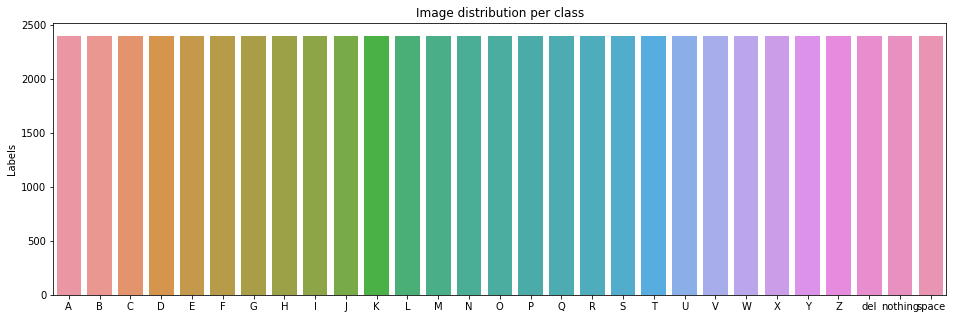

In [ ]:
category_values = label_df['Labels'].value_counts()
plt.figure(figsize=(16,5))
plt.tight_layout(pad=0.5)
plt.title("Image distribution per class")
sns.barplot(x = sorted(category_values.index), y=category_values);

Some sample images from the training set

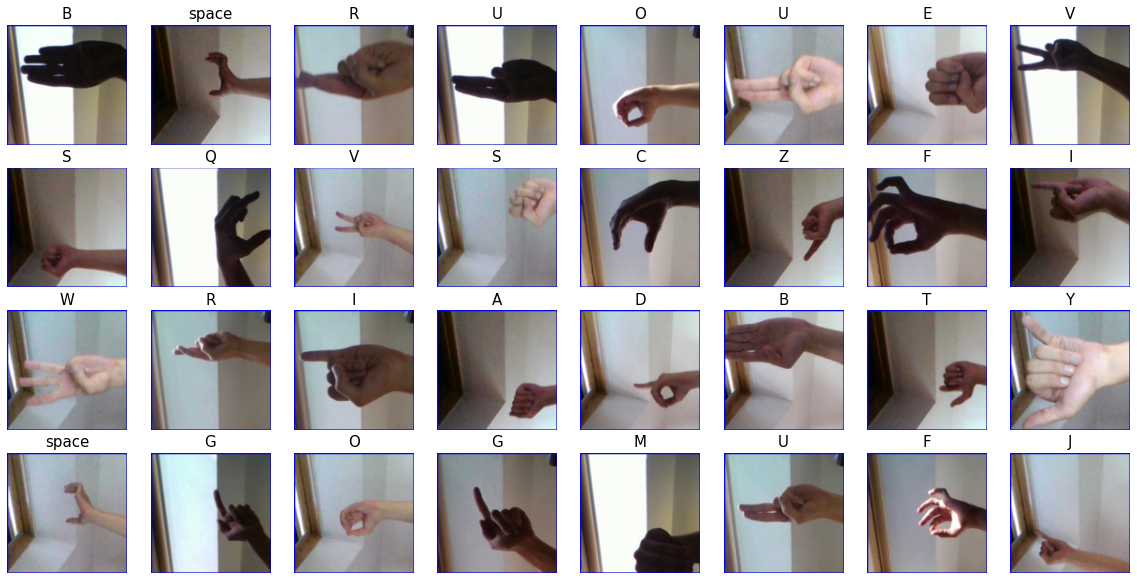

In [ ]:
figure = plt.figure(figsize=(16, 8))
cols, rows= 8,4
for i in range(1, cols*rows +1 ):
  sample_id = torch.randint(len(train_dataset), size=(1,)).item()
  img, label = train_dataset[sample_id]
  figure.add_subplot(rows, cols, i)
  plt.title(img_labels[label], fontsize=15)
  plt.axis("off")
  plt.imshow(img.permute(2,1,0).squeeze())

plt.tight_layout(pad=0.5)
plt.show()

## Hyperparameters

In [ ]:
# hyperparameters

EPOCH = 5
BATCH = 100
model =  CNN_Model()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()

In [ ]:
# loading the datasets into dataloaders 

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH, shuffle=True)

# Training the model

In [ ]:
def training(loader):
  loss_trn = list()
  acc_trn = list()

  loss_val = list()
  acc_val = list()
  
  for epoch in tqdm(range(EPOCH)):
    epoch_loss = []
    for step, (img, labels) in enumerate(loader):
 
      img, labels = img.to(DEVICE), labels.to(DEVICE)
      predicted = model(img)
      loss = loss_function(predicted, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss.append(loss.item())

      total = labels.size(0)
      _, output = torch.max(predicted.data, 1)
      correct = (output == labels).sum().item()

      if step % 100 == 0:
        print(f'\n{epoch} epoch(s) with training loss {loss.item():.4f}')
        print(f'Accuracy: {(correct/total)*100:.2f}%')
        with torch.no_grad():
          model.eval()
          c_val, t_val, l_val = 0, 0, 0
          for img, labels in val_dataloader:
            img, labels = img.to(DEVICE), labels.to(DEVICE)
            predicted = model(img)
            loss = loss_function(predicted, labels)
            l_val = l_val + loss.item()

            _, output =  torch.max(predicted.data, 1)
            c_val = (output == labels).sum().item()
            t_val = labels.size(0)

        print(f'\nValidation loss is {l_val / len(val_dataloader):.4f}')
        print(f'Validation accuracy is {(c_val/t_val)*100:.2f}%')

        loss_val.append(l_val / len(val_dataloader))
        acc_val.append(c_val/t_val)

        loss_trn.append(sum(epoch_loss)/len(epoch_loss))
        acc_trn.append(correct/total)
  
  torch.save(model.state_dict(), "./model.pth")
  return loss_trn, acc_trn, loss_val, acc_val

start_time = time.time()

loss_trn, acc_trn, loss_val, acc_val = training(train_dataloader)
print(f'\nTime taken to train the model on {EPOCH} epochs was {time.time() - start_time:.2f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]


0 epoch(s) with training loss 3.3612
Accuracy: 4.00%

Validation loss is 6.4736
Validation accuracy is 3.00%

0 epoch(s) with training loss 3.4318
Accuracy: 3.00%

Validation loss is 3.4046
Validation accuracy is 7.00%

0 epoch(s) with training loss 2.9941
Accuracy: 14.00%

Validation loss is 2.9472
Validation accuracy is 19.00%

0 epoch(s) with training loss 2.2704
Accuracy: 31.00%

Validation loss is 2.4241
Validation accuracy is 22.00%

0 epoch(s) with training loss 1.8916
Accuracy: 46.00%

Validation loss is 1.8880
Validation accuracy is 52.00%

0 epoch(s) with training loss 1.4289
Accuracy: 59.00%

Validation loss is 1.5010
Validation accuracy is 55.00%

0 epoch(s) with training loss 1.0968
Accuracy: 72.00%

Validation loss is 1.1542
Validation accuracy is 70.00%


 20%|██        | 1/5 [03:25<13:41, 205.37s/it]


1 epoch(s) with training loss 0.8856
Accuracy: 77.00%

Validation loss is 0.9084
Validation accuracy is 76.00%

1 epoch(s) with training loss 0.6027
Accuracy: 79.00%

Validation loss is 0.7162
Validation accuracy is 83.00%

1 epoch(s) with training loss 0.6057
Accuracy: 85.00%

Validation loss is 0.6211
Validation accuracy is 84.00%

1 epoch(s) with training loss 0.4168
Accuracy: 87.00%

Validation loss is 0.4883
Validation accuracy is 87.00%

1 epoch(s) with training loss 0.5108
Accuracy: 88.00%

Validation loss is 0.4101
Validation accuracy is 92.00%

1 epoch(s) with training loss 0.3715
Accuracy: 94.00%

Validation loss is 0.3477
Validation accuracy is 91.00%

1 epoch(s) with training loss 0.2119
Accuracy: 95.00%

Validation loss is 0.2973
Validation accuracy is 98.00%


 40%|████      | 2/5 [06:50<10:15, 205.23s/it]


2 epoch(s) with training loss 0.2016
Accuracy: 97.00%

Validation loss is 0.2571
Validation accuracy is 96.00%

2 epoch(s) with training loss 0.1625
Accuracy: 98.00%

Validation loss is 0.2243
Validation accuracy is 97.00%

2 epoch(s) with training loss 0.1740
Accuracy: 97.00%

Validation loss is 0.1913
Validation accuracy is 97.00%

2 epoch(s) with training loss 0.1639
Accuracy: 98.00%

Validation loss is 0.1656
Validation accuracy is 98.00%

2 epoch(s) with training loss 0.1224
Accuracy: 98.00%

Validation loss is 0.1490
Validation accuracy is 96.00%

2 epoch(s) with training loss 0.0686
Accuracy: 100.00%

Validation loss is 0.1338
Validation accuracy is 98.00%

2 epoch(s) with training loss 0.0965
Accuracy: 98.00%

Validation loss is 0.1077
Validation accuracy is 99.00%


 60%|██████    | 3/5 [10:15<06:50, 205.15s/it]


3 epoch(s) with training loss 0.1267
Accuracy: 96.00%

Validation loss is 0.1040
Validation accuracy is 96.00%

3 epoch(s) with training loss 0.0711
Accuracy: 99.00%

Validation loss is 0.1230
Validation accuracy is 95.00%

3 epoch(s) with training loss 0.0679
Accuracy: 98.00%

Validation loss is 0.0910
Validation accuracy is 99.00%

3 epoch(s) with training loss 0.0890
Accuracy: 98.00%

Validation loss is 0.0955
Validation accuracy is 99.00%

3 epoch(s) with training loss 0.1058
Accuracy: 98.00%

Validation loss is 0.1238
Validation accuracy is 97.00%

3 epoch(s) with training loss 0.0499
Accuracy: 100.00%

Validation loss is 0.0777
Validation accuracy is 100.00%

3 epoch(s) with training loss 0.0598
Accuracy: 98.00%

Validation loss is 0.0679
Validation accuracy is 98.00%


 80%|████████  | 4/5 [13:40<03:25, 205.07s/it]


4 epoch(s) with training loss 0.0563
Accuracy: 99.00%

Validation loss is 0.0857
Validation accuracy is 96.00%

4 epoch(s) with training loss 0.0346
Accuracy: 100.00%

Validation loss is 0.0490
Validation accuracy is 100.00%

4 epoch(s) with training loss 0.0378
Accuracy: 100.00%

Validation loss is 0.0537
Validation accuracy is 99.00%

4 epoch(s) with training loss 0.0477
Accuracy: 99.00%

Validation loss is 0.0668
Validation accuracy is 99.00%

4 epoch(s) with training loss 0.0208
Accuracy: 100.00%

Validation loss is 0.0726
Validation accuracy is 96.00%

4 epoch(s) with training loss 0.0549
Accuracy: 100.00%

Validation loss is 0.0551
Validation accuracy is 99.00%

4 epoch(s) with training loss 0.0447
Accuracy: 99.00%

Validation loss is 0.0462
Validation accuracy is 100.00%


100%|██████████| 5/5 [17:05<00:00, 205.06s/it]



Time taken to train the model on 5 epochs was 1025.60 seconds


## Training and Validation Loss

Here we compare the loss between the training set and validation set encountered while training the model 

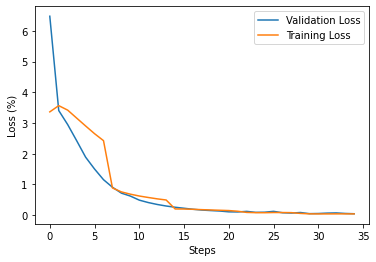

In [ ]:
plt.plot(loss_val, label='Validation Loss')
plt.plot(loss_trn, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss (%)')
plt.legend();

## Training and Validation Accuracy

Here we compare the accuracy observed between the training set and validation set while training the mode

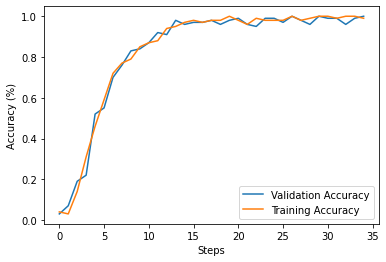

In [ ]:
plt.plot(acc_val, label='Validation Accuracy')
plt.plot(acc_trn, label='Training Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy (%)')
plt.legend();

## Summary of the model

Display the model's contents and the number of parameters it requires

In [ ]:
summary(model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             448
          Hardtanh-2         [-1, 16, 126, 126]               0
         MaxPool2d-3           [-1, 16, 62, 62]               0
            Conv2d-4           [-1, 32, 62, 62]           4,640
          Hardtanh-5           [-1, 32, 62, 62]               0
         MaxPool2d-6           [-1, 32, 30, 30]               0
            Linear-7                 [-1, 1000]      28,801,000
          Hardtanh-8                 [-1, 1000]               0
            Linear-9                   [-1, 29]          29,029
Total params: 28,835,117
Trainable params: 28,835,117
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 6.46
Params size (MB): 110.00
Estimated Total Size (MB): 116.64
---------------------------------

# Evaluation metric

Method to get the labels of all predictions

In [ ]:
@torch.no_grad()
def get_predictions(loader):
  all_pred = torch.tensor([]).to(DEVICE)
  all_labels = torch.tensor([]).to(DEVICE)
  all_images = torch.tensor([]).to(DEVICE)

  for img, labels in loader:
    img, labels = img.to(DEVICE), labels.to(DEVICE)
    pred = model(img)
    _, predicted = torch.max(pred.data, 1)
    all_images = torch.cat((all_images, img))
    all_labels = torch.cat((all_labels, labels))
    all_pred = torch.cat((all_pred, predicted))
  return all_labels.cpu(), all_pred.cpu(), all_images.cpu()

all_labels, all_pred, all_images = get_predictions(test_dataloader)

## Confusion Matrix

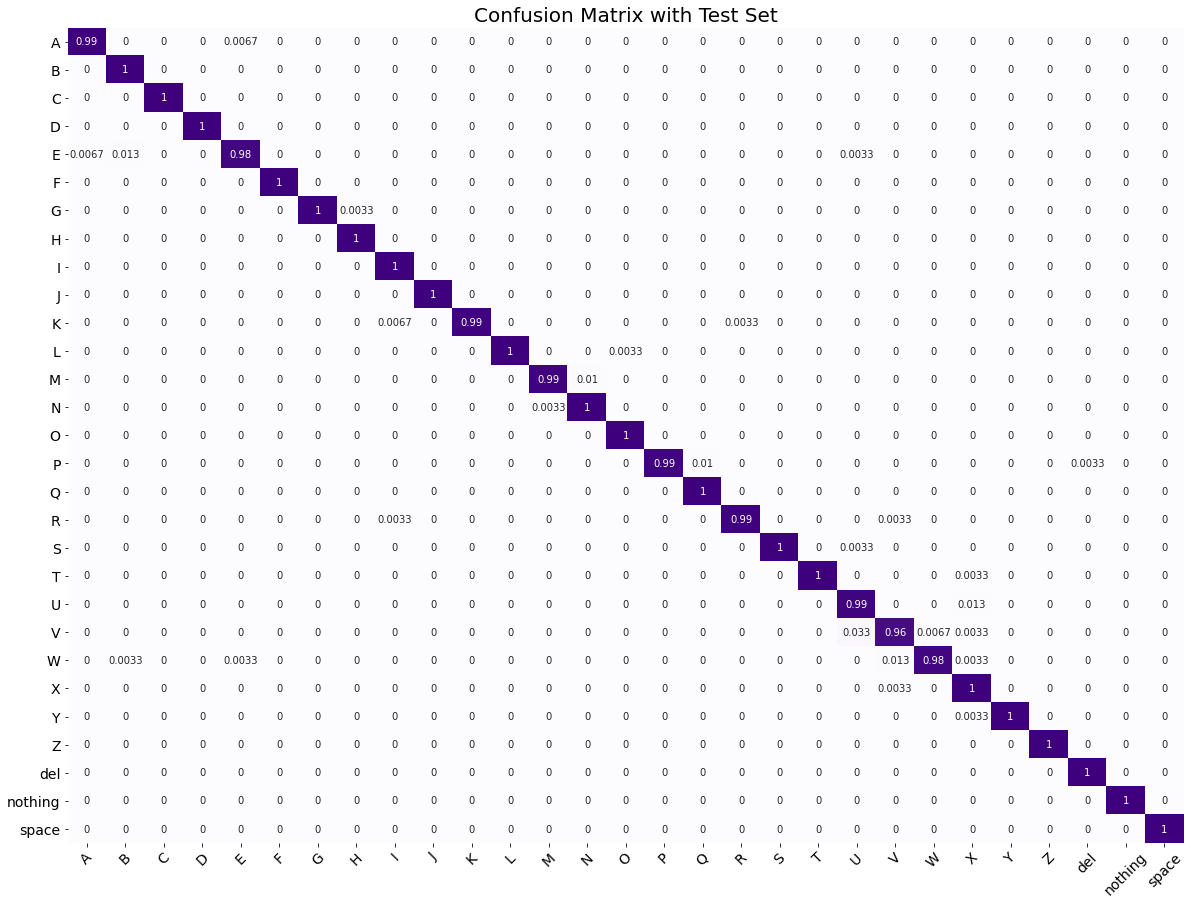

In [ ]:
def conf_matrix(labels, predictions, title):
  cm = confusion_matrix(labels, predictions, normalize='true')
  plt.figure(figsize=(20, 15))
  sns.heatmap(cm, annot=True ,xticklabels=label_df['Labels'].unique(), 
              yticklabels=label_df['Labels'].unique(), cbar=False, 
              cmap="Purples")
  plt.xticks(fontsize=14 ,rotation=45)
  plt.yticks(fontsize=14)
  plt.title(title, fontsize=20)
  plt.show()

conf_matrix(all_labels, all_pred, "Confusion Matrix with Test Set")

## Accuracy, Recall and Precision score

In [ ]:
confusion_mtx = confusion_matrix(all_labels, all_pred)

true_positives = np.diag(confusion_mtx)
false_positives = confusion_mtx[:].sum(axis=0) - np.diag(confusion_mtx)
false_negatives = confusion_mtx[:].sum(axis=1) - np.diag(confusion_mtx)
true_negatives = confusion_mtx[:].sum() - (true_positives + false_positives + false_negatives)

true_positive = true_positives[:].sum()
false_positive = false_positives[:].sum()
false_negative = false_negatives[:].sum()
true_negative = true_negatives[:].sum()

accuracy = (true_positive + true_negative)/(true_positive + false_positive + false_negative + true_negative)
precision = (true_positive)/(true_positive + false_positive)
recall = (true_positive)/(true_positive + false_positive)


print(f'Accuracy: {accuracy*100:.4f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 99.9588%
Precision: 0.9940
Recall: 0.9940



## True Positives, True Negatives, False Positives, False Negatives

In [ ]:


scores_df = pd.DataFrame(list(zip(true_positives, false_positives, false_negatives, true_negatives)), 
                          columns=['True Positives','False Positives','False Negatives','True Negatives']).astype(int)
scores_df = scores_df.append(scores_df.sum().rename('Total'))
display(scores_df)

,True Positives,False Positives,False Negatives,True Negatives
0,298,2,2,8398
1,300,5,0,8395
2,300,0,0,8400
3,300,0,0,8400
4,293,3,7,8397
5,300,0,0,8400
6,299,0,1,8400
7,300,1,0,8399
8,300,3,0,8397
9,300,0,0,8400


# Predictions

In [ ]:
# predictions dataframe
preds_df = pd.DataFrame(all_pred, columns=['Predictions']).astype(int)
preds_df['Predictions'] = preds_df['Predictions'].apply(lambda x: img_labels[x])

# test dataframe
test_label_df = pd.DataFrame(all_labels, columns=['Labels'])
test_label_df['Labels'] = test_label_df['Labels'].apply(lambda x: img_labels[x])

Present different cases with their True and Predicted labels

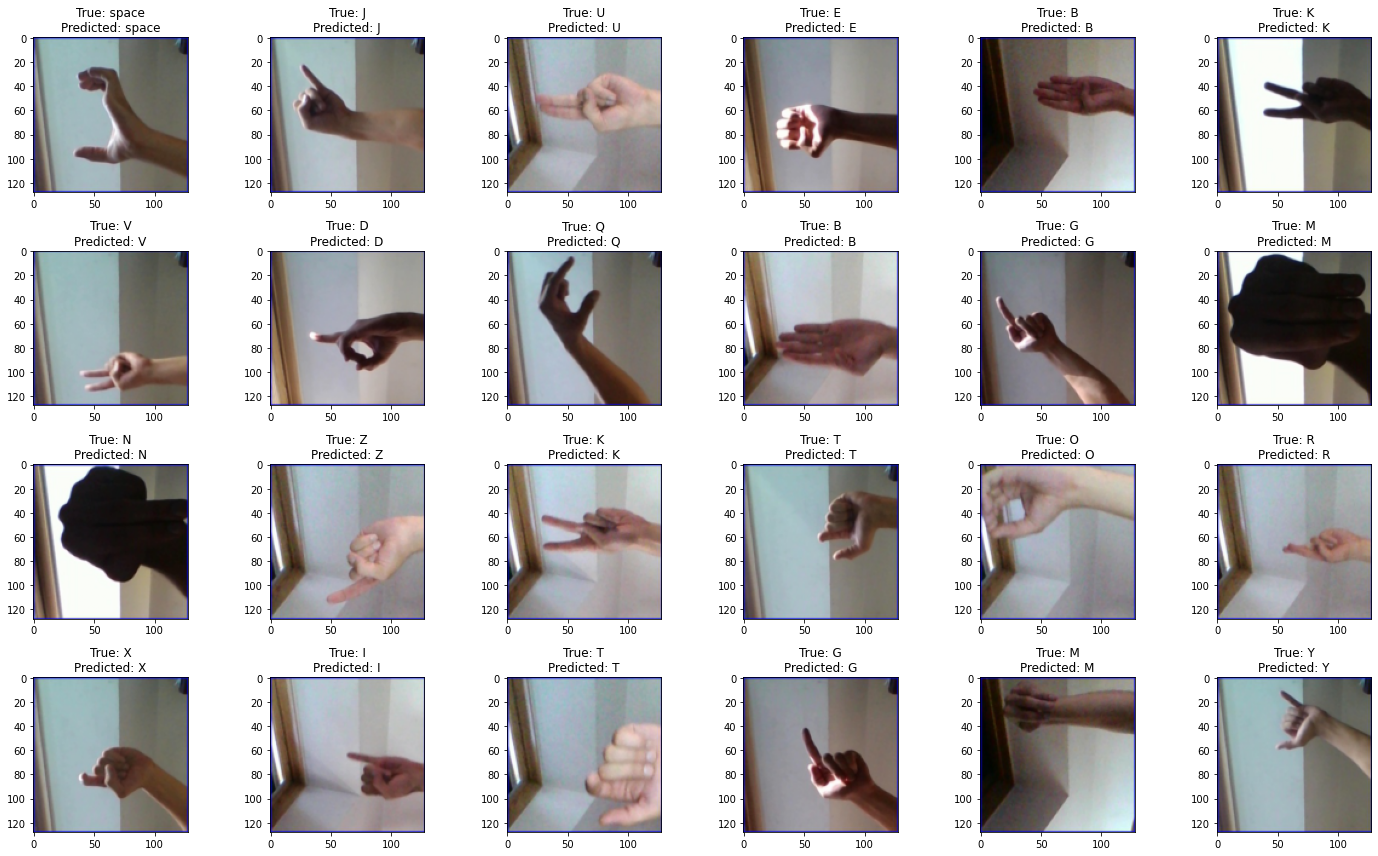

In [ ]:
cols, rows= 6,4
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 12))

for i, ax in enumerate(ax.flat):
  ax.imshow(all_images[i].permute(2,1,0).squeeze())
  ax.set_title(f"True: {test_label_df['Labels'].iloc[i]}\nPredicted: {preds_df['Predictions'].iloc[i]}")

plt.tight_layout()
plt.show()